# VOLD Ratio and Bolliinger Bands

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [68]:
def plotting(financial_data, basis, upper, lower, not_active):
    print("Not active: ", not_active)
    plt.plot(financial_data.index, basis,
             label='Basis', color='yellow', alpha=0.5)
    plt.fill_between(financial_data.index, upper, lower,
                     label='Background', color='lightblue', alpha=0.7)
    plt.fill_between(financial_data.index, upper, basis, where=(
        upper > basis), label='Buy Zone', color='green', alpha=0.7)
    plt.fill_between(financial_data.index, lower, basis, where=(
        lower < basis), label='Sell Zone', color='red', alpha=0.7)

    # plot the data with the offset
    plt.plot(financial_data.index,
             financial_data['Close'], label='Close Price', color='blue')

    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title('VOLD Ratio and Bollinger Bands')
    plt.legend()
    plt.grid(True)

In [69]:

def void_ratio(financial_data: pd.DataFrame, record_to_plot: int = None):
    # Calculate vold ratio
    # Can only use .dt accessor with datetimelike values
    # time data "13.05.2003 01:00:00.000" doesn't match format "%m.%d.%Y %H:%M:%S.%f",
    # try "13.05.2003 01:00:00.000" instead
    financial_data['date'] = pd.to_datetime(
        financial_data['date'], format="%d.%m.%Y %H:%M:%S.%f")
    financial_data = financial_data[:record_to_plot]
    is_new_time = np.append(
        np.diff(financial_data['date']) > pd.Timedelta(seconds=0), True)

    up_net_volume = np.where(
        financial_data['Close'] > financial_data['Open'], financial_data['Volume'], 0)
    down_net_volume = np.where(
        financial_data['Close'] < financial_data['Open'], financial_data['Volume'], 0)

    up_vol = np.nan
    down_vol = np.nan
    unv = []
    dnv = []

    for idx, new_time in enumerate(is_new_time):
        if new_time:
            up_vol = up_net_volume[idx]
            down_vol = down_net_volume[idx]
            unv.append(up_vol)
            dnv.append(down_vol)
        else:
            if not np.isnan(up_vol):
                up_vol = up_net_volume[idx]
                unv.append(up_vol)
            if not np.isnan(down_vol):
                down_vol = down_net_volume[idx]
                dnv.append(down_vol)

    net_valup = np.sum(unv)
    net_valdown = np.sum(dnv)

    vold = net_valup / net_valdown

    # Plot vold ratio
    plt.figure(figsize=(10, 6))
    plt.plot(financial_data.index, [
             vold] * len(financial_data.index), label='VOLD Ratio', color='white', alpha=0.5)

    # Bollinger Bands
    length = 50
    src = vold
    mult = 2.0

    basis = financial_data['Close'].rolling(window=length).mean()
    dev = mult * financial_data['Close'].rolling(window=length).std()
    upper = basis + dev
    lower = basis - dev

    # Signalling
    # Buy when the Close price crosses above the
    # Sell when the Close price crosses below the lower band

    financial_data["signal"] = 0

    # if the close price is greater than the basis, and lower than the upper band, buy
    # if the close price is greater than the upper band
    # if the close price is less than the lower band sell
    # if the close price is less than the basis, and greater than the lower band, sell
    last_signal = None
    not_active = 0
    temp_low = 0
    temp_high = 0
    for i in range(length, len(financial_data)):
        if last_signal != 'sell':
            if financial_data['Close'][i] < lower[i] and i < len(financial_data):
                plt.plot(i, financial_data['Close'][i], marker='o', color='green')
                last_signal = 'sell'
                financial_data.loc[i, "signal"] = 1
                continue 
            
        if last_signal != 'sell':
            if financial_data['Close'][i] > upper[i] and i < len(financial_data):
                plt.plot(i, financial_data['Close'][i], marker='o', color='green')
                last_signal = 'sell'
                financial_data.loc[i, "signal"] = 1
                continue
        
        if last_signal != 'buy':
            if financial_data['Close'][i] < basis[i] and i < len(financial_data):
                plt.plot(i, financial_data['Close'][i], marker='o', color='red')
                last_signal = 'buy'
                financial_data.loc[i, "signal"] = 2
                continue
        
        if last_signal != 'buy':
            if financial_data['Close'][i] > lower[i] and i < len(financial_data):
                plt.plot(i, financial_data['Close'][i], marker='o', color='red')
                last_signal = 'buy'
                financial_data.loc[i, "signal"] = 2 
                continue
            
        not_active += 1

    plotting(financial_data, basis, upper, lower, not_active)

    if record_to_plot is not None:
        plt.show()
    else:
        return vold

    return financial_data




In [70]:
financial_data = pd.read_csv("..\data\EURUSD_Candlestick_4_Hour_ASK_05.05.2003-16.10.2021.csv")

# delete dollar sign
try:
    # Clean up dollar signs and convert columns to numeric values
    financial_data["Close/Last"] = financial_data["Close/Last"].str.replace(
        "$", "").astype(float)
    financial_data["Open"] = financial_data["Open"].str.replace(
        "$", "").astype(float)
    financial_data["High"] = financial_data["High"].str.replace(
        "$", "").astype(float)
    financial_data["Low"] = financial_data["Low"].str.replace(
        "$", "").astype(float)
except Exception:
    pass

# rename the headers
try:
    financial_data.rename(columns={"Close/Last": "Close"}, inplace=True)
except Exception:
    pass



#if financial_data.iloc[0]['Close'] > financial_data.iloc[-1]['Close']:
#    financial_data = financial_data[::-1]

financial_data.rename(columns={"high": "High"}, inplace=True)
financial_data.rename(columns={"low": "Low"}, inplace=True)
financial_data.rename(columns={"open": "Open"}, inplace=True)
financial_data.rename(columns={"volume": "Volume"}, inplace=True)
financial_data.rename(columns={"close": "Close"}, inplace=True)




financial_data = financial_data.reset_index(drop=True)

C:\Users\bobek\AppData\Local\Temp\ipykernel_18260\4257725561.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  financial_data["signal"] = 0


Not active:  599


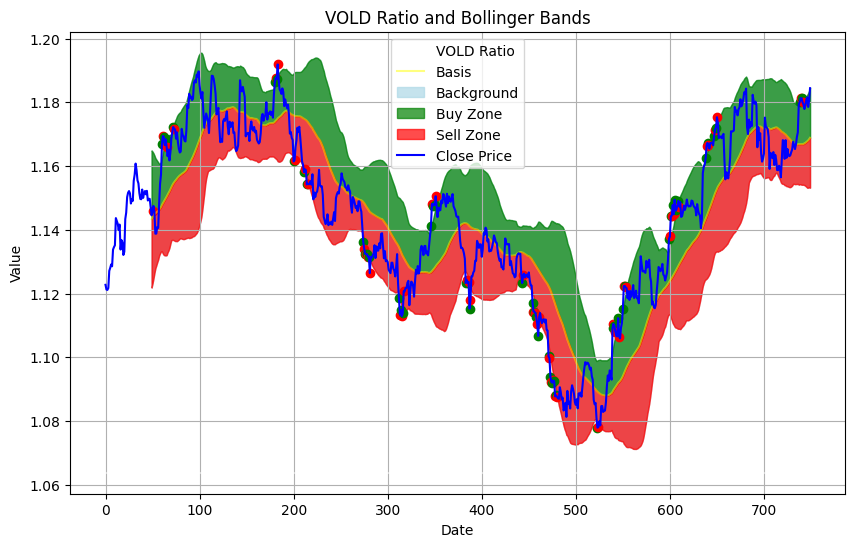

In [71]:
financial_data = void_ratio(financial_data, 750)

In [72]:
from apply_backtesting import backtester
import backtesting

# import output_notebook
from bokeh.io import output_notebook
output_notebook()

backtesting.set_bokeh_output(notebook=True)


bt,stats = backtester(financial_data)
bt.run()
bt.plot()

Loading BokehJS ...

c:\Users\bobek\QuantWiseAI\jupiter_notebooks\apply_backtesting.py:34: UserWarning: Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.
  bt = Backtest(financial_data, MyCandlesStrat, cash=10_000, commission=.00)


51
50


Row(id='4601', ...)

In [73]:
print(stats)

Start                                     0.0
End                                     749.0
Duration                                749.0
Exposure Time [%]                        74.0
Equity Final [$]                  12049.59117
Equity Peak [$]                   12076.01176
Return [%]                          20.495912
Buy & Hold Return [%]                5.494594
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                   -3.446407
Avg. Drawdown [%]                   -0.512809
Max. Drawdown Duration                  143.0
Avg. Drawdown Duration              11.767442
# Trades                                 27.0
Win Rate [%]                        92.592593
Best Trade [%]                       4.141828
Worst Trade [%]                     -0.508459
Avg. Trade [%]                    

## Results

- Return: 20.5%
- Buy & Hold Return: 5.5%
- Win Rate: 92.6%
